# Import packages and shape files:

In [77]:
import pandas as pd
import seaborn as sns
import os

# you need to define the  PROJ_LIB env variable if the basemap package is installed on your root enviroment:
os.environ["PROJ_LIB"]=".\\anaconda3\\Library\\share"

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as Polygonpatch
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# set the path to your U.S. state and zip code shapefiles
us_state_shp=".\\shape file\\cb_2017_us_state_500k\\cb_2017_us_state_500k"
us_zipcode_shp=".\\shape file\\USA_ZIP_Codes\\USA_ZIP_Codes"

sns.set()

# Import and organize the dataset:

In [4]:
data=pd.read_csv(".\\16zpallagi.csv")
print(data.head(10))

   STATEFIPS STATE  zipcode  agi_stub      N1   mars1   MARS2   MARS4    PREP  \
0          1    AL        0         1  815440  477700  105350  221200  440830   
1          1    AL        0         2  495830  211930  142340  128890  272440   
2          1    AL        0         3  263390   83420  137870   36340  154880   
3          1    AL        0         4  167190   29420  124060   10610   99700   
4          1    AL        0         5  217440   20240  188080    4880  129410   
5          1    AL        0         6   57240    2970   51130     400   42920   
6          1    AL    35004         1    1510     990     220     280     700   
7          1    AL    35004         2    1410     660     360     340     630   
8          1    AL    35004         3     950     330     470     140     440   
9          1    AL    35004         4     650     120     470      50     320   

        N2   ...     N10300   A10300  N85530  A85530  N85300  A85300  N11901  \
0  1296920   ...     367320 

In [5]:
# drop the rows where zipcode==0, since it is the sum by state
data=data[data.zipcode!=0]
# check if the dataset contains a comprehensive list of state and zipcode
print(data.STATE.unique())
print("Number of States: "+ str(len(data.STATE.unique())))
print(data.zipcode.unique())
print("Number of Zip code: "+ str(len(data.zipcode.unique())))

['AL' 'AK' 'AZ' 'AR' 'CA' 'CO' 'CT' 'DE' 'DC' 'FL' 'GA' 'HI' 'ID' 'IL'
 'IN' 'IA' 'KS' 'KY' 'LA' 'ME' 'MD' 'MA' 'MI' 'MN' 'MS' 'MO' 'MT' 'NE'
 'NV' 'NH' 'NJ' 'NM' 'NY' 'NC' 'ND' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD'
 'TN' 'TX' 'UT' 'VT' 'VA' 'WA' 'WV' 'WI' 'WY']
Number of States: 51
[35004 35005 35006 ... 83127 83128 83414]
Number of Zip code: 29873


# Clean the dataset.
### Focus on the variables of interest:
**A00100: "Adjust gross income"**   
**A02650: "Total income amount"**  
**A00300: "Taxable interest amount"**  
**A00600: "Ordinary dividends amount"**  
**A00700: "State and local income tax refunds amount"**  
**A07100: "Total tax credits amount"**  
**A00900: "Business or professional net income (less loss) amount"**  
**A18425: "State and local income taxes amount"**  
**A04800: "Taxable income amount"**  
**A10600: "Total tax payments amount"**  
**A06500: "Income tax amount"**  

In [6]:
# create summary statistics
print(data[["A00100","A02650","A00300","A00600","A00700","A07100","A00900","A18425", "A04800","A10600","A06500"]].describe())

             A00100        A02650         A00300        A00600         A00700  \
count  1.794900e+05  1.794900e+05  179490.000000  1.794900e+05  179490.000000   
mean   5.710747e+04  5.792029e+04     434.147730  1.241957e+03     175.900139   
std    1.766541e+05  1.791645e+05    3846.361938  1.187208e+04    1109.735813   
min    0.000000e+00  0.000000e+00       0.000000  0.000000e+00       0.000000   
25%    3.217000e+03  3.261000e+03       5.000000  0.000000e+00       0.000000   
50%    1.264950e+04  1.283400e+04      53.000000  9.700000e+01      11.000000   
75%    5.326675e+04  5.405275e+04     261.000000  5.660000e+02      76.000000   
max    1.049680e+07  1.053782e+07  443298.000000  2.854370e+06  117309.000000   

              A07100         A00900        A18425        A04800        A10600  \
count  179490.000000  179490.000000  1.794900e+05  1.794900e+05  1.794900e+05   
mean      332.951379    1873.305404  1.835624e+03  4.002768e+04  9.739672e+03   
std      1341.214447    591

In [37]:
# aggregate data to zip code and state level
data_aggre_zip=data.groupby(by="zipcode",as_index=False, sort=False).sum()
data_aggre_state=data.groupby(by="STATE",as_index=False, sort=False).sum()
# convert the dollar amount into millions (already reported in thousands)
# calculate average for each dollar amount (N1:Number of returns)
# calculate percent of returns prepared by volunteers
for df in [data, data_aggre_zip, data_aggre_state]:
    for var in ["A00100","A02650","A00300","A00600","A00700",
                "A07100","A00900","A18425", "A04800","A10600","A06500"]:
        new_var="scaled_"+var
        df[new_var]=df[var]/1000
        new_var='avg_'+var
        df[new_var]=df[var]/df.N1
    df["pct_volunteer_prepare"]=df["TOTAL_VITA"]/df["N1"]


# Analyse the dataset 

**To have a good understanding of the dataset, a useful first step to take is to look at its distribution.
 A simple yet informative set of histrograms can accomplish this task**

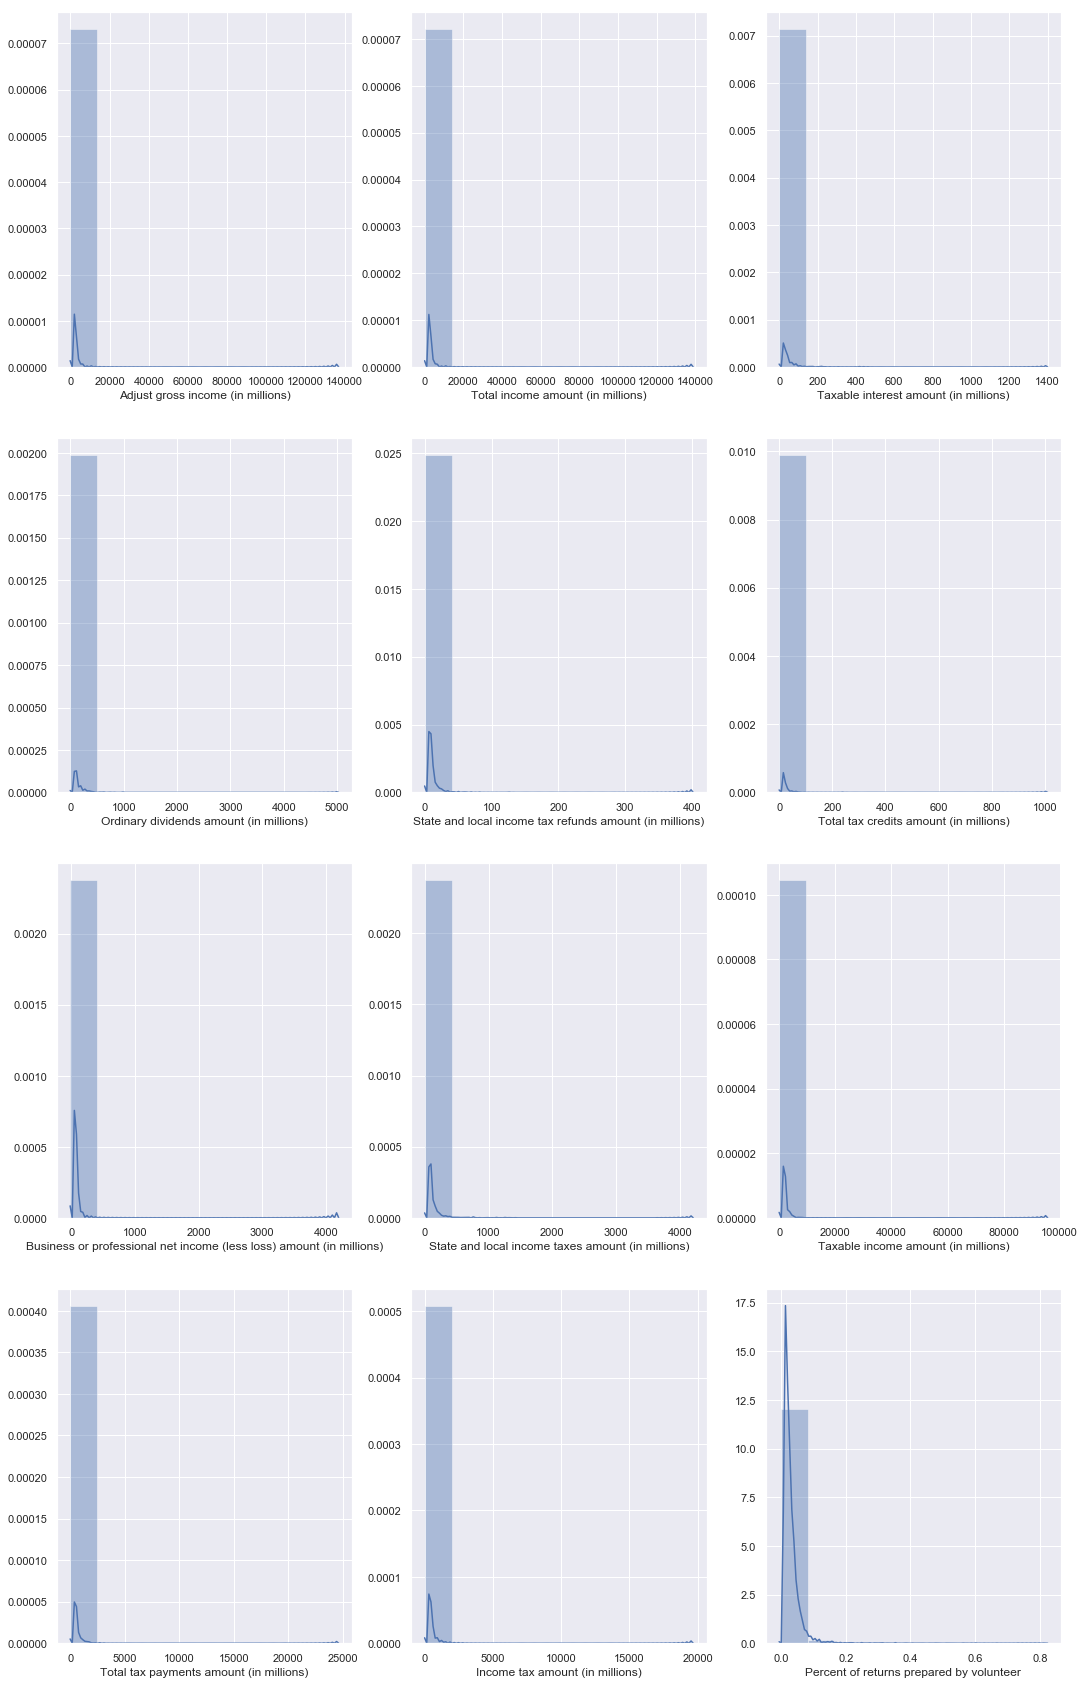

In [49]:
# create variable dictionary 
var_plot={"scaled_A00100" : "Adjust gross income (in millions)" ,"scaled_A02650":"Total income amount (in millions)",
          "scaled_A00300":"Taxable interest amount (in millions)","scaled_A00600":"Ordinary dividends amount (in millions)",
          "scaled_A00700":"State and local income tax refunds amount (in millions)","scaled_A07100":"Total tax credits amount (in millions)",
          "scaled_A00900": "Business or professional net income (less loss) amount (in millions)","scaled_A18425":"State and local income taxes amount (in millions)",
          "scaled_A04800" : "Taxable income amount (in millions)","scaled_A10600" : "Total tax payments amount (in millions)","scaled_A06500":"Income tax amount (in millions)",
          "pct_volunteer_prepare" : "Percent of returns prepared by volunteer"}
ind=0
figure=plt.figure(figsize=(18,30))
while ind<12:
    plt.subplot(4,3,ind+1)
    sns.distplot(data_aggre_zip[list(var_plot.keys())[ind]],hist=True, bins=10)
    plt.xlabel(var_plot[list(var_plot.keys())[ind]])
    ind+=1

**All the histrograms are right skewed, suggesting a big variation in income and tax payment amount. The majority of the population receive relatively low income and pay relatively low tax.**

**This information is useful, however, we might be able to gain more information on the dataset by looking at the distribution by income level.** 

**Based on the previous histograms, we see that the population at the top of the income group causes the right skew. 
Including this relatively small group in the hisgram obscures a lot of helpful information. So in the next set of histograms, we exclude the top income group (adjusted gross income $200,000 or more)**

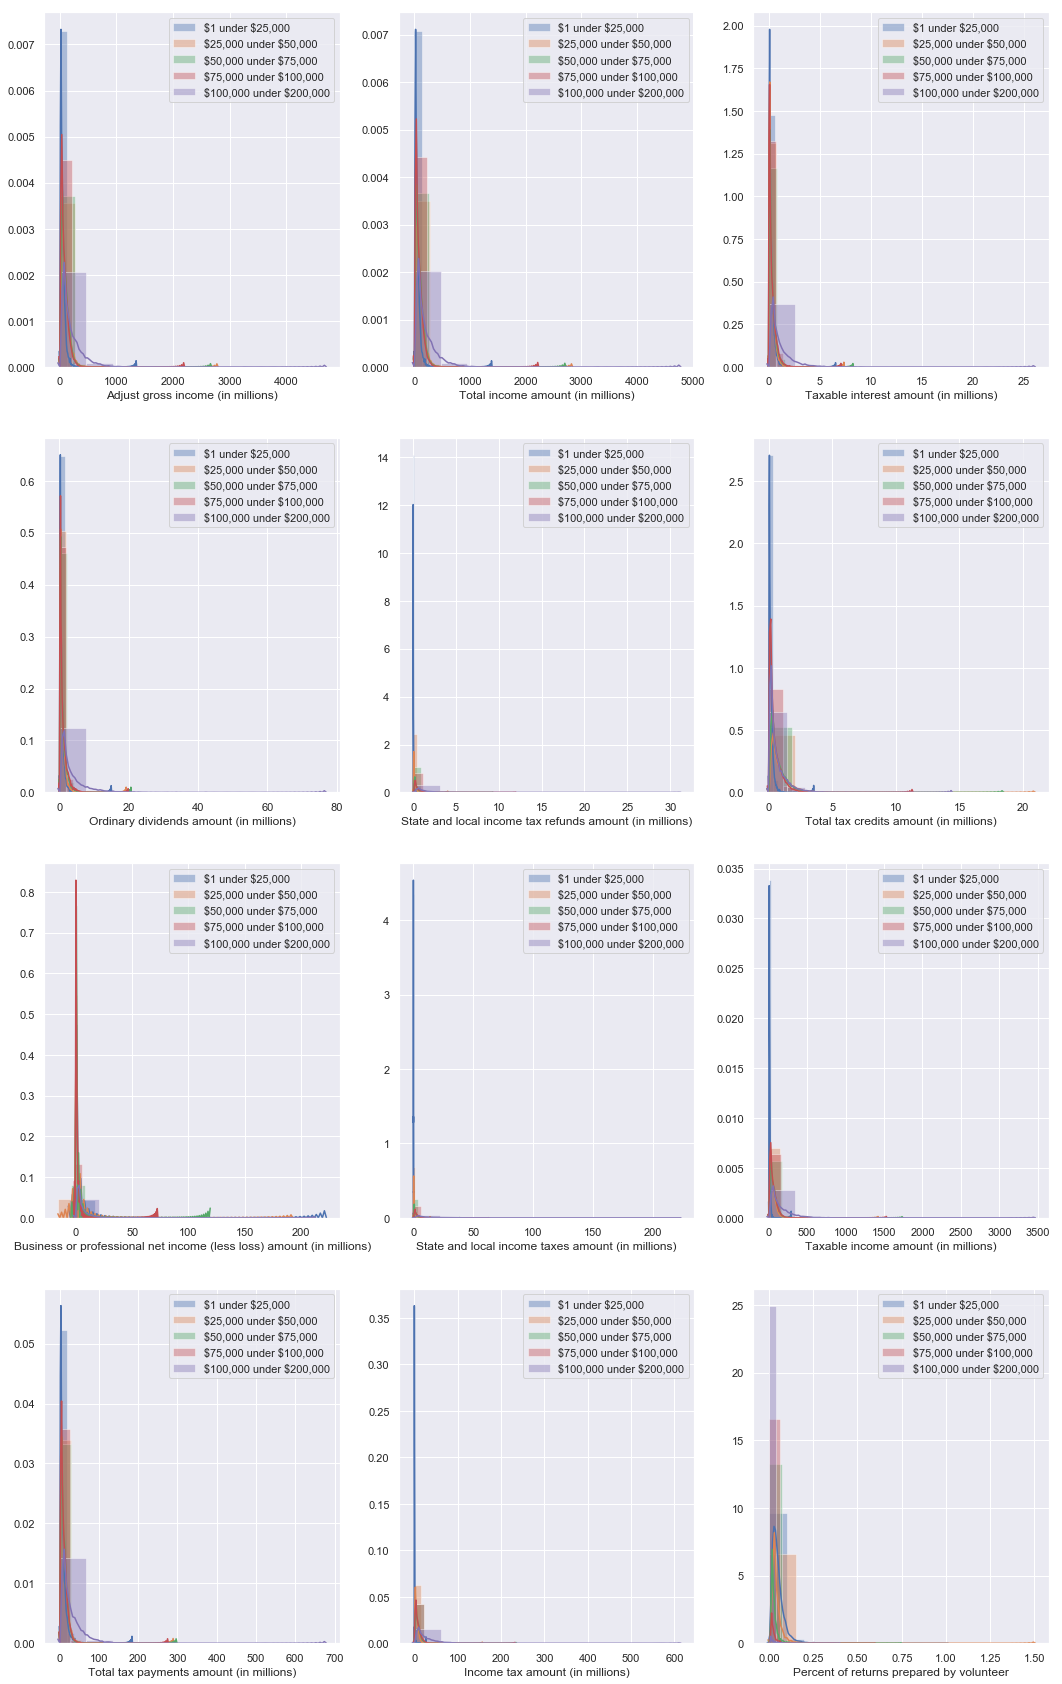

In [54]:
# variable agi_stub: Size of adjusted gross income
category={1:"\$1 under \$25,000", 2 :"\$25,000 under \$50,000",3:"\$50,000 under \$75,000",
          4:"\$75,000 under \$100,000", 5:"\$100,000 under \$200,000"}  #, 6:"\$200,000 or more"}
ind=0
figure=plt.figure(figsize=(18,30))
while ind<12:
    plt.subplot(4,3,ind+1)
    for num in list(category.keys()):
        sub_data=data[data.agi_stub==num].dropna(subset=['pct_volunteer_prepare'])
        sns.distplot(sub_data[list(var_plot.keys())[ind]],hist=True, bins=10,label=category[num])
        plt.legend()
        plt.xlabel(var_plot[list(var_plot.keys())[ind]])
    ind+=1

**Two interesting observation based on the above set of histograms:**
1. **the higher the income gorup, the more income variation there is in on zip code level.**
2. **The higher income groups have lower percent of population whose tax is prepared by volunteers**

**Having some idea about the distribution of our dataset is just the first step. It does not reveal other interesting characteristics of the dataset, such as the relationship between variables. We can use other visualization tools to uncover these characteristics. Here is an example using spacial visualization:**

Text(0.15, 0.25, '$\\bf{Sources:}$ Internal Revenue Service')

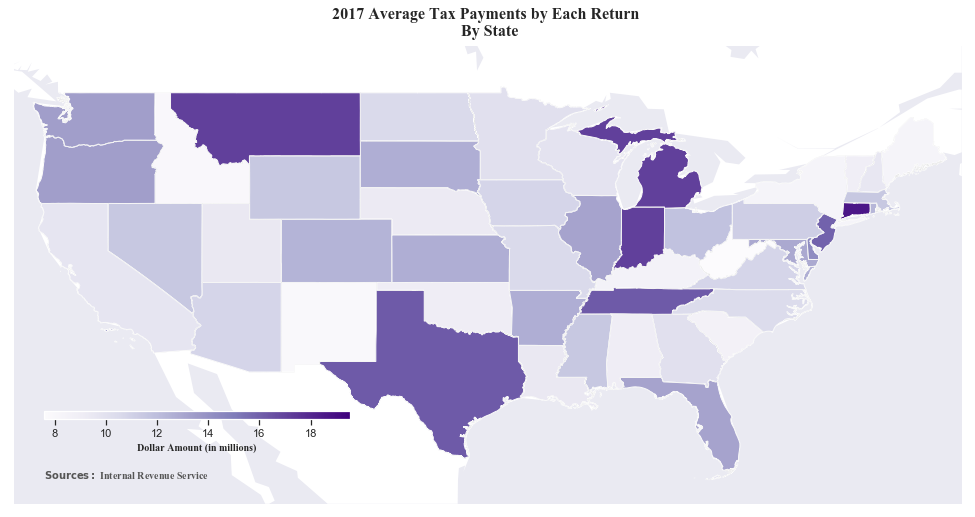

In [79]:
fig,ax = plt.subplots()
fig.set_size_inches(17,11)
m=Basemap(llcrnrlon=-126,llcrnrlat=23,urcrnrlon=-66,urcrnrlat=52,projection='cyl',resolution='c')
m.fillcontinents(color='white',zorder=0)
m.readshapefile(us_state_shp,'state',drawbounds=True,linewidth=0.1,color='lightgrey')

m.drawmapboundary(color='white')
STATE_1=[]
for i in m.state_info:
    STATE_1+=[i['STUSPS']]

norm=Normalize()

cmap =cm.get_cmap('Purples')
patches=[]
color=[]
for STATE_2, geo in zip(STATE_1, m.state):
    target=data_aggre_state[data_aggre_state.STATE==STATE_2]
    color+=(target.avg_A10600).tolist() 
    poly=Polygonpatch(geo,closed=True,zorder=2) 
    patches.append(poly)
collection=PatchCollection(patches)
collection.set_facecolor(cmap(norm(color)))
ax.add_collection(collection)

mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
mapper.set_array([0,1,0.2])
cbaxes = fig.add_axes([0.15,0.32,0.25,0.01])
cbar=plt.colorbar(mapper, orientation='horizontal', cax=cbaxes)
cbar.set_label('Dollar Amount (in millions)',fontname='Times New Roman',size=10)

ax.set_title("2017 Average Tax Payments by Each Return \n By State",size=16,fontname='Times New Roman',verticalalignment='bottom',weight='normal')
fig.text( 0.15, 0.25,'$\\bf{Sources:}$ Internal Revenue Service', ha='left', va='center', 
         size=10, color='#555555',fontname='Times New Roman')

**Surprisingly (or not?), the population that, on average, contributes the most to tax revenue reside in Montana, Taxas, Tennessee, Indiana, Michigan, and Connecticut!**

**Lets take a look at the total tax contribution by state:**

Text(0.15, 0.25, '$\\bf{Sources:}$ Internal Revenue Service')

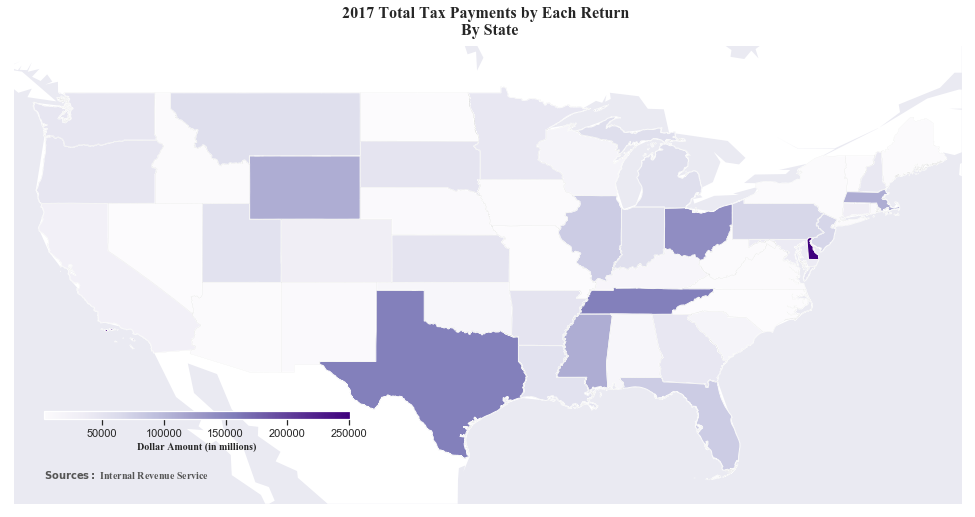

In [80]:
fig,ax = plt.subplots()
fig.set_size_inches(17,11)
m=Basemap(llcrnrlon=-126,llcrnrlat=23,urcrnrlon=-66,urcrnrlat=52,projection='cyl',resolution='c')
m.fillcontinents(color='white',zorder=0)
m.readshapefile(us_state_shp,'state',drawbounds=True,linewidth=0.1,color='lightgrey')

m.drawmapboundary(color='white')
STATE_1=[]
for i in m.state_info:
    STATE_1+=[i['STUSPS']]

norm=Normalize()

cmap =cm.get_cmap('Purples')
patches=[]
color=[]
for STATE_2, geo in zip(STATE_1, m.state):
    target=data_aggre_state[data_aggre_state.STATE==STATE_2]
    color+=(target.scaled_A10600).tolist() 
    poly=Polygonpatch(geo,closed=True,zorder=2) 
    patches.append(poly)
collection=PatchCollection(patches)
collection.set_facecolor(cmap(norm(color)))
ax.add_collection(collection)

mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
mapper.set_array([0,1,0.2])
cbaxes = fig.add_axes([0.15,0.32,0.25,0.01])
cbar=plt.colorbar(mapper, orientation='horizontal', cax=cbaxes)
cbar.set_label('Dollar Amount (in millions)',fontname='Times New Roman',size=10)

ax.set_title("2017 Total Tax Payments by Each Return \n By State",size=16,fontname='Times New Roman',verticalalignment='bottom',weight='normal')
fig.text( 0.15, 0.25,'$\\bf{Sources:}$ Internal Revenue Service', ha='left', va='center', 
         size=10, color='#555555',fontname='Times New Roman')

**The ranking shifted quite a bit, suggesting wide differences in population and income across states.**

**After seeing the tax payment distribution across states, we can take a look at the tax distribution at a more granula geographic level to gain more insights. What about across zip code area? Will tax payment variation be as big across zip code areas? Will the zip code areas covered by darker color in the previous maps also have higher tax payments?**

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x23234267c50>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x23234267f60>)

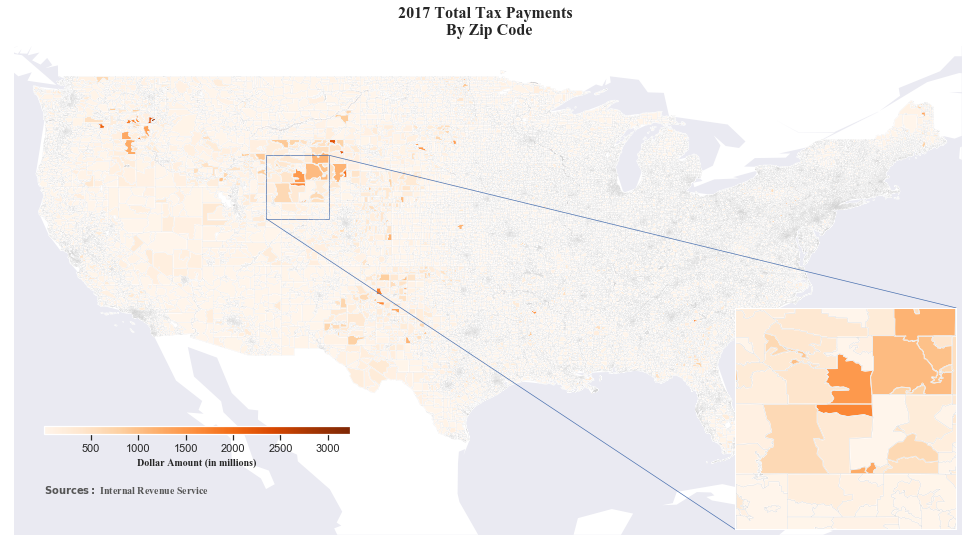

In [78]:
fig,ax = plt.subplots()
fig.set_size_inches(17,11)
m=Basemap(llcrnrlon=-126,llcrnrlat=20,urcrnrlon=-66,urcrnrlat=51,projection='cyl',resolution='c')

m.fillcontinents(color='white',zorder=0)
m.readshapefile(us_zipcode_shp,'zipcode',drawbounds=True,linewidth=0.1,color='lightgrey')
m.drawmapboundary(color='white')

zipcode_1=[]
for i in m.zipcode_info:
    zipcode_1+=[int(i['ZIP'])]

norm=Normalize()

cmap =cm.get_cmap('Oranges')
patches=[]
color=[]
for zipcode_2, geo in zip(zipcode_1, m.zipcode):
    target=data_aggre_zip[data_aggre_zip.zipcode==zipcode_2]
    color+=(target.scaled_A10600).tolist()   
    poly=Polygonpatch(geo,closed=True,zorder=2) 
    patches.append(poly)
collection=PatchCollection(patches)
collection.set_facecolor(cmap(norm(color)))
ax.add_collection(collection)

mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
mapper.set_array([0,1,0.2])
cbaxes = fig.add_axes([0.15,0.32,0.25,0.01])
cbar=plt.colorbar(mapper, orientation='horizontal', cax=cbaxes)
cbar.set_label('Dollar Amount (in millions)',fontname='Times New Roman',size=10)

ax.set_title("2017 Total Tax Payments \n By Zip Code",size=16,fontname='Times New Roman',verticalalignment='bottom',weight='normal')
fig.text( 0.15, 0.25,'$\\bf{Sources:}$ Internal Revenue Service', ha='left', va='center', 
         size=10, color='#555555',fontname='Times New Roman')

# Add map inset
axins = zoomed_inset_axes(ax, 3.5, loc=4, axes_kwargs={"alpha":0.8})
#axins.set_xlim(-104, -98)
axins.set_ylim(33, 37)
axins.set_xlim(-110, -106)
axins.set_ylim(40, 44)

plt.xticks(visible=False)
plt.yticks(visible=False)

m2 = Basemap(llcrnrlon=-110,llcrnrlat=40,urcrnrlon=-106,urcrnrlat=44, ax=axins)
#m2 = Basemap(llcrnrlon=-123,llcrnrlat=36,urcrnrlon=-120,urcrnrlat=40, ax=axins)
m2.fillcontinents(color='white',zorder=0)
m2.readshapefile(us_zipcode_shp,'zipcode',drawbounds=True,linewidth=0.2,color='lightgrey')

m2.drawmapboundary(color='white')
zipcode_1=[]
for i in m.zipcode_info:
    zipcode_1+=[int(i['ZIP'])]

norm=Normalize()

cmap =cm.get_cmap('Oranges')
patches=[]
color=[]
for zipcode_2, geo in zip(zipcode_1, m2.zipcode):
    target=data_aggre_zip[data_aggre_zip.zipcode==zipcode_2]
    color+=(target.scaled_A10600).tolist()   
    poly=Polygonpatch(geo,closed=True,zorder=2) 
    patches.append(poly)
collection=PatchCollection(patches)
collection.set_facecolor(cmap(norm(color)))
axins.add_collection(collection)

mark_inset(ax, axins, loc1=1, loc2=3, fc="none", lw=0.7, ec='b')

**Compared to previous maps, this visualization of total tax payment by zip code area tells a very different story. Areas covered by Wyoming have relatively higher contribution to tax than other areas. Moreover, west America contributes more to total tax than east America.**

**We can zoom in to obtain a clearer picture of the distribution of tax payments to a specific region. This map shows an example of the Wyoming/SouthDakota/Nebraska region.** 

**At a high conpetual level, this map is probably a little bit counter-intuitive. We would expect the east and the west coast to be covered in darker color. The cause for the difference might be that the map is made at the zip code level. Since the richer areas tend to have smaller zip code areas, it is harder to distinguish them from the map, even if they have dark colors.**


# Conclusion


**We just walked through together an example of using spatial visualization to gain a deeper understanding of a dataset. Mastering this techinique could allow us to do much more than is showed here. For example, we can make a set of tax payment maps by year and analyse how tax payment distribution changes by year for each state or zip code area.** 

**Of course, the purpose of this technique is not to make cool visual presentations. We can use these maps to answer a lot of important questions, such as the development of equality.**